In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, inspect, func, desc

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)


In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
#
#

In [11]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [12]:
#determining columns from each table
m_columns = inspector.get_columns('measurement')
print("Measurement columns:")
for m in m_columns:
    print(m['name'],m['type'])
print()
s_columns = inspector.get_columns('station')
print("Station columns:")
for s in s_columns:
    print(s['name'],s['type'])

Measurement columns:
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT

Station columns:
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [13]:
# Calculate the date 1 year ago from the last data point in the database

latest_date = session.query(Measurement).order_by(desc('date')).first()
print(latest_date.date)

2017-08-23


In [45]:
#joining tables
# Perform a query to retrieve the data and precipitation scores

sel = Measurement.id,Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation,Measurement.date,Measurement.prcp,Measurement.tobs
df_sel = Measurement.id,Measurement.date,Measurement.prcp
df_tb = session.query(*df_sel).filter(Measurement.station == Station.station)\
                                .filter(Measurement.date > '2016-08-23').all()

In [53]:
# query results as a Pandas DataFrame and set the index to the date column
# Sort the dataframe by date

#full_df = pd.DataFrame(merged_tb,columns=['Index','Station','Station_Name','Latitiude','Longitude','Elevation','Date','Precipitation','Temperature'])
df = pd.DataFrame(df_tb,columns=['Index','Date','Precipitation'])
df = df.drop(columns=['Index'])
df = df.dropna()
df.sort_values(by=['Date'],inplace=True,ascending=True)
df.set_index('Date',inplace=True)

df.head(5)

,Precipitation
Date,
2016-08-24,0.08
2016-08-24,1.22
2016-08-24,2.28
2016-08-24,1.45
2016-08-24,2.15


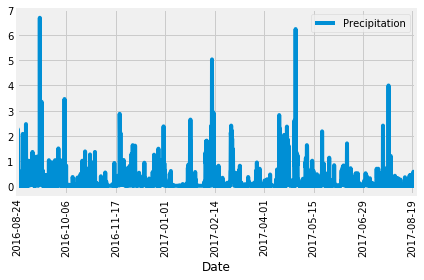

In [74]:
# Use Pandas Plotting with Matplotlib to plot the data
df_chart = df.plot(grid=True,rot=90).get_figure()
plt.tight_layout()
df_chart.savefig('Precipitation_by_Date.png')

In [75]:
# Use Pandas to calculate the summary statistics for the precipitation data
df.describe()

,Precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [ ]:
### STATION ANALYSIS

In [90]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(func.count(Station.station)).all()
station_count

[(9)]

In [108]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.

obs_by_station = session.query(Measurement.station, func.count(Measurement.tobs)).group_by(Measurement.station).\
                order_by(func.count(Measurement.tobs).desc()).all()
obs_by_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [124]:
# ANSWER: USC00519281 has the highest count
top_obs_station = obs_by_station[0][0]
top_obs_station

'USC00519281'

In [130]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
max_temp = session.query(func.max(Measurement.tobs)).filter(Measurement.station == top_obs_station).all()
min_temp = session.query(func.min(Measurement.tobs)).filter(Measurement.station == top_obs_station).all()
avg_temp = session.query(func.avg(Measurement.tobs)).filter(Measurement.station == top_obs_station).all()
print(f"The maximum temperature recorded at {top_obs_station} was {max_temp[0][0]} degrees.")
print(f"The minimum temperature recorded at {top_obs_station} was {min_temp[0][0]} degrees.")
print(f"The average temperature recorded at {top_obs_station} was {round(avg_temp[0][0],0)} degrees.")

The maximum temperature recorded at USC00519281 was 85.0 degrees.
The minimum temperature recorded at USC00519281 was 54.0 degrees.
The average temperature recorded at USC00519281 was 72.0 degrees.


In [ ]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram


In [284]:
#temp_data = session.query(Measurement.tobs,func.count(Measurement.tobs)).filter(Measurement.date > '2016-08-23').group_by(Measurement.tobs).order_by(Measurement.tobs).all()
temp_data = session.query(Measurement.tobs).filter(Measurement.date > '2016-08-23').filter(Measurement.station == top_obs_station).all()
temp_df = pd.DataFrame(temp_data)
temp_df.head()

,tobs
0,77.0
1,80.0
2,80.0
3,75.0
4,73.0


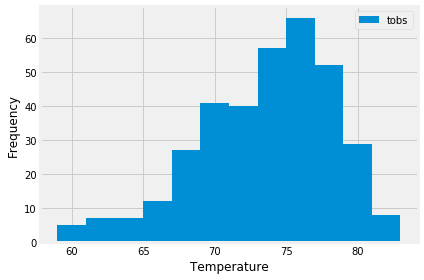

In [301]:
temp_chart = temp_df.plot.hist(bins=12).get_figure()
plt.xlabel("Temperature")
plt.tight_layout()
temp_chart.savefig('Temp_Histogram.png')


## Bonus Challenge Assignment

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
